# Model Interpretation for Pretrained ResNet Model

This notebook demonstrates how to apply model interpretability algorithms on pretrained ResNet model using a handpicked image and visualizes the attributions for each pixel by overlaying them on the image.

The interpretation algorithms that we use in this notebook are `Integrated Gradients` (w/ and w/o noise tunnel),  `GradientShap`, and `Occlusion`. A noise tunnel allows to smoothen the attributions after adding gaussian noise to each input sample.
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

In [2]:
import torch
import torch.nn.functional as F

import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from model import load_densenet_mlp, HierarchicalResidual
from utils import dicom_img

## 1- Loading the model and the dataset


Loads pretrained Resnet model and sets it to eval mode

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def load_cac_detect(path_model):
    model = HierarchicalResidual(encoder='densenet121')
    del model.fc1
    del model.fc2
    
    model.fc =  torch.nn.Sequential(
            torch.nn.Linear(1024, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 2))
            
    dict_model = torch.load(path_model)["model"]
    model.load_state_dict(dict_model)

    return model


In [5]:
PATH_MODEL = '/home/fiodice/project/src/best/calcium-detection-sdg-seed-42-fold-2.pt'
model = load_cac_detect(PATH_MODEL)
model.to(device)

Using cache found in /home/fiodice/.cache/torch/hub/pytorch_vision_v0.6.0


HierarchicalResidual(
  (encoder): Sequential(
    (0): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

Defines transformers and normalizing functions for the image.
It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

In [6]:
mean, std = [0.5024], [0.2898]

transform = transforms.Compose([ transforms.Resize((1248,1248)),
                                 transforms.CenterCrop(1024),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std),
])

path_img = '/home/fiodice/project/dataset_split/test/CAC_001.1/rx/IM-0001-0001-0001.dcm'

img, _ = dicom_img(path_img)

transformed_img = transform(img)

input = transformed_img.unsqueeze(0)
input = input.to(device)

Predict the class of the input image

In [7]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')

Predicted: tensor(1, device='cuda:0') ( 0.5998629927635193 )


## 2- Gradient-based attribution

Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

In [8]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=3)

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.93 GiB total capacity; 7.22 GiB already allocated; 7.75 MiB free; 7.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Let's visualize the image and corresponding attributions by overlaying the latter on the image.

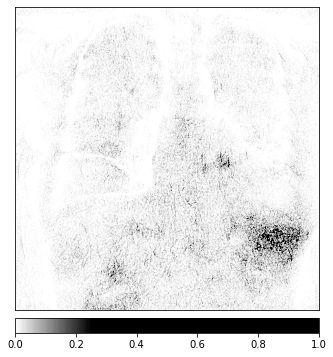

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

input_attr = np.transpose(attributions_ig.squeeze(0).cpu().detach().numpy(), (1,2,0))
input_img = np.transpose(input.squeeze(0).cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr(input_attr,
                             input_img,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (nt_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `nt_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `nt_samples` samples.

In [ ]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Error: Canceled future for execute_request message before replies were done

Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## 3- Occlusion-based attribution

Now let us try a different approach to attribution. We can estimate which areas of the image are critical for the classifier's decision by occluding them and quantifying how the decision changes.

We run a sliding window of size 15x15 (defined via `sliding_window_shapes`) with a stride of 8 along both image dimensions (a defined via `strides`). At each location, we occlude the image with a baseline value of 0 which correspondes to a gray patch (defined via `baselines`).

**Note:** this computation might take more than one minute to complete, as the model is evaluated at every position of the sliding window.

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

NameError: name 'viz' is not defined

The upper part of the goose, especially the beak, seems to be the most critical for the model to predict this class.

We can verify this further by occluding the image using a larger sliding window:

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )